In [1]:
#!/usr/bin/env python
import sys
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.insert(1, '/human_prediction')
from nbformat import write
# import rospy
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import matplotlib as mpl
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d,Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from human_prediction.quat_functions import *
import os
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean, minkowski
from human_prediction.network import *
# import rospkg
from human_prediction.skeleton import *
from scipy import interpolate as interp
import time
from scipy.signal import butter, lfilter
from scipy.spatial.transform import Rotation as R
import plotly.graph_objects as go
import chart_studio.plotly as py
import chart_studio
import copy
chart_studio.tools.set_credentials_file(username='jaredflowers', api_key='VeLAc61z7yFkI2FUMj3Y')
%matplotlib inline

In [35]:

if __name__ == '__main__':

    this_pack = os.path.split(os.getcwd())[0]
    print(this_pack)

    file_num = 4013
    speeds = np.empty((0))
    final_errors = np.empty((0))
    start_delays = np.empty((0))
    peak_vels = np.empty((0))
    dists = np.empty((0))
    durations = np.empty((0))
    prediction = np.genfromtxt(os.path.join(this_pack,'data','prediction_{}.csv'.format(file_num)),dtype=float,delimiter=',')
    print('opening recording_{}'.format(file_num))
    data = np.genfromtxt(os.path.join(this_pack,'data','recording_{}.csv'.format(file_num)),dtype=float,delimiter=',')
    wrist = False #false = right, true = left
    l_wrist_vels = np.linalg.norm(np.diff(data[:,[60,61,62]],axis=0),axis=1)
    r_wrist_vels = np.linalg.norm(np.diff(data[:,[51,52,53]],axis=0),axis=1)
    l_wrist_errors = np.linalg.norm(data[:,[60,61,62]]-data[:,[1,2,3]],axis=1)
    r_wrist_errors = np.linalg.norm(data[:,[51,52,53]]-data[:,[1,2,3]],axis=1)

    l_wrist_error_avg = np.zeros_like(l_wrist_errors)
    r_wrist_error_avg = np.zeros_like(r_wrist_errors)
    l_wrist_error_vels_avg = np.zeros_like(l_wrist_error_avg)
    r_wrist_error_vels_avg = np.zeros_like(r_wrist_error_avg)
    d_starts =np.empty((0))
    filt = butter(1, 0.001, btype='lowpass', analog=False)
    # d_starts.append(0)
    d_stops = np.empty((0))
    in_div = False
    v1s =np.zeros_like(r_wrist_error_avg)
    v2s =np.zeros_like(r_wrist_error_avg)
    m = 20
    d_start = 0
    accs = np.zeros_like(r_wrist_error_avg)
    num_sgn_flips = 0
    first_sgn_flip = 0
    max_deviation = 0
    min_out_dev = 10
    tmp_start = 0
    start_i = 0
    for i in range(l_wrist_errors.shape[0]):
        l_wrist_error_avg[i] = np.mean(l_wrist_errors[max(i-20,0):i+1])
        r_wrist_error_avg[i] = np.mean(r_wrist_errors[max(i-20,0):i+1])
        if i>0:
            l_wrist_error_vels_avg[i] = np.mean(np.diff(l_wrist_error_avg[max(i-50,0):i+1]))
            r_wrist_error_vels_avg[i] = np.mean(np.diff(r_wrist_error_avg[max(i-50,0):i+1]))
            if wrist:
                accs[i] = np.mean(np.diff(l_wrist_error_vels_avg[max(i-20,0):i+1]))
            else:
                accs[i] = np.mean(np.diff(r_wrist_error_vels_avg[max(i-20,0):i+1]))
            if data[i,0]<data[i-1,0]:
                start_i = i
        else: 
            l_wrist_error_vels_avg[i] = 0
            r_wrist_error_vels_avg[i] = 0
            accs[i] = 0
    print(data.shape)
    print(start_i)
    data[start_i:,0] += data[start_i-1,0]
    start_i-=20
    start_i = max(0,start_i)
    pred_start=data[start_i,0]
    stop_i=-140
    pre_start_errors = r_wrist_errors[:start_i]
    pre_start_error_avg = r_wrist_error_avg[:start_i]
    data = data[start_i:stop_i,:]
    l_wrist_errors = l_wrist_errors[start_i:stop_i]
    r_wrist_errors = r_wrist_errors[start_i:stop_i]
    l_wrist_vels = l_wrist_vels[start_i:stop_i]
    r_wrist_vels = r_wrist_vels[start_i:stop_i]
    accs = accs[start_i:stop_i]
    l_wrist_error_avg = l_wrist_error_avg[start_i:stop_i]
    r_wrist_error_avg = r_wrist_error_avg[start_i:stop_i]
    l_wrist_error_vels_avg = l_wrist_error_vels_avg[start_i:stop_i]
    r_wrist_error_vels_avg = r_wrist_error_vels_avg[start_i:stop_i]
    
    

C:\Users\jared\Documents\human_predicition
opening recording_4013
(288, 81)
47


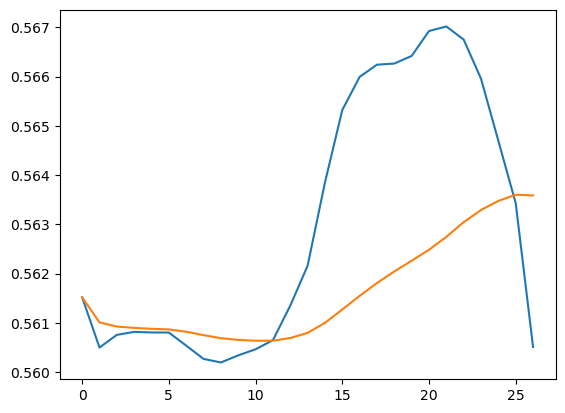

In [36]:
fig = plt.figure()
plt.plot(pre_start_errors)
plt.plot(pre_start_error_avg)
plt.show()


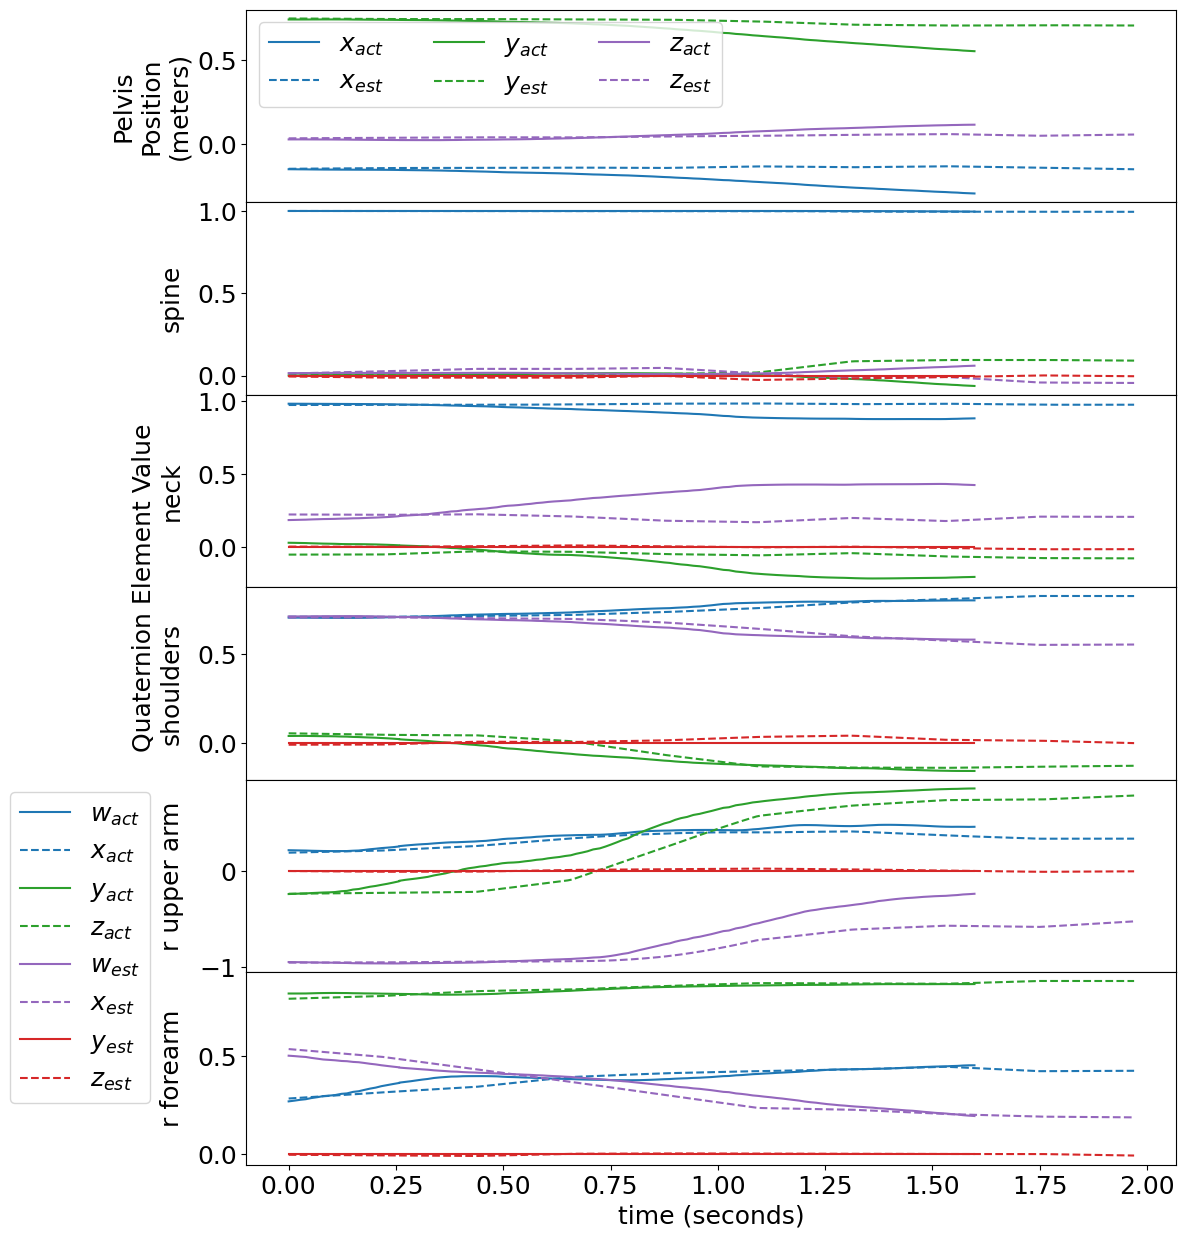

In [37]:
%matplotlib inline
x = data[:,0]-data[0,0]
pred_x = prediction[:,0]+pred_start-data[0,0]
labels = ['spine','neck', 'shoulders','r upper arm', 'r forearm', 'l upper arm', 'l forearm']
colors = ['tab:blue','tab:green','tab:purple','tab:red']
if not wrist:
    quats = np.array([0,1,2,3,4])
else:
    quats = np.array([0,1,2,5,6])
fig3, ax3 = plt.subplots(6,1,sharex=True,figsize=(12,15))
lbl = ['x','y','z']
f_size = 18
for i in range(3):
    ax3[0].plot(x,data[:,5+i],color=colors[i],label=r'${}$'.format(lbl[i]+'_{act}'))
    # ax[0].plot(np.linspace(0,net.sequence_length,true_pose_data.shape[0]),true_pose_data[:,3:6])
    ax3[0].plot(pred_x,prediction[:,1+i],color=colors[i],linestyle='dashed',label=r'${}$'.format(lbl[i]+'_{est}'))
ax3[0].legend(fontsize=f_size,ncols=3)    
ax3[0].tick_params(labelsize=f_size)
ax3[0].set_ylabel('Pelvis\nPosition\n(meters)',fontsize=f_size)

for i in range(5):
#     ax3[i+1].set_title(labels[quats[i]],fontsize=f_size,pad=-30, y=1.0,bbox=(dict(edgecolor='white',facecolor='white',alpha=0.8)))
    ax3[i+1].text(-0.08,0.5,labels[quats[i]],rotation=90, horizontalalignment='center',verticalalignment='center', transform=ax3[i+1].transAxes,fontsize=f_size)
#     ax[i+1].plot(np.linspace(0,net.sequence_length,true_pose_data.shape[0]),true_pose_data[:,i*4+6:i*4+10])
    prediction[:,i*4+4:i*4+8] = prediction[:,i*4+4:i*4+8]/np.linalg.norm(prediction[:,i*4+4:i*4+8],axis=1).reshape((prediction.shape[0],1))
    for j in range(4):
        ax3[i+1].plot(x,data[:,8+j+i*4],color=colors[j])
        ax3[i+1].plot(pred_x,prediction[:,4+j+i*4],color=colors[j],linestyle='dashed')
    ax3[i+1].tick_params(labelsize=f_size)
ax3[4].legend([r'$w_{act}$',r'$x_{act}$',r'$y_{act}$',r'$z_{act}$',r'$w_{est}$',r'$x_{est}$',r'$y_{est}$',r'$z_{est}$'],fontsize=f_size,ncols=1,loc='upper right', bbox_to_anchor=(-0.09,1.0))
ax3[3].text(-0.11,1.0,'Quaternion Element Value',rotation=90, horizontalalignment='center',verticalalignment='center', transform=ax3[3].transAxes,fontsize=f_size)
ax3[-1].set_xlabel('time (seconds)',fontsize=f_size)
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

plotting right errors


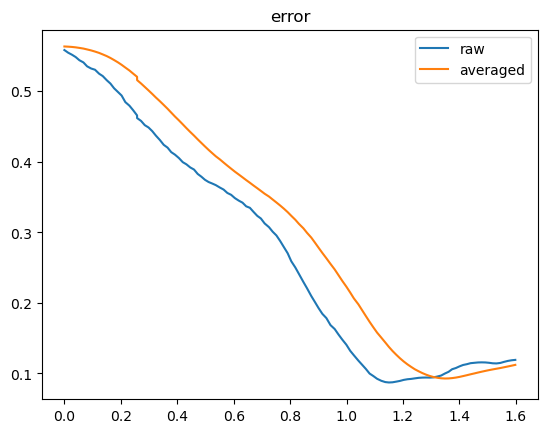

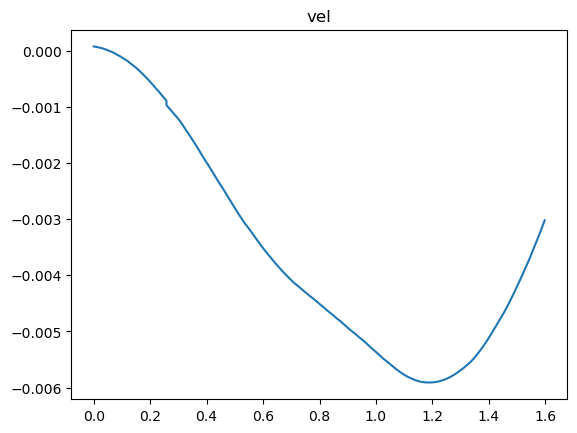

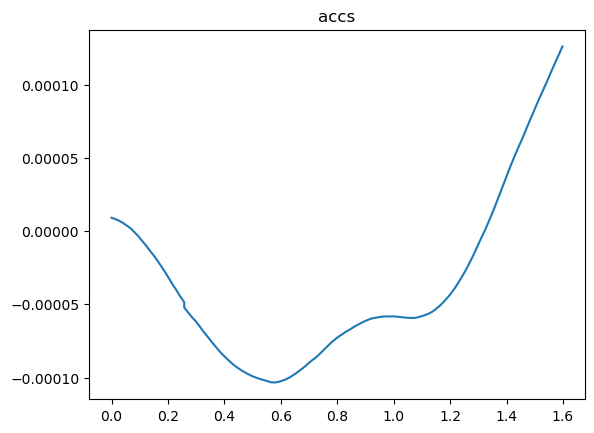

In [38]:
x = data[:,0]-data[0,0]
pred_x = prediction[:,0]
labels = ['spine','neck', 'shoulders','r upper', 'r forearm', 'l upper arm', 'l forearm']
colors = ['tab:blue','tab:green','tab:purple','tab:red']
if not wrist:
    quats = np.array([0,1,2,3,4])
else:
    quats = np.array([0,1,2,5,6])
fig8,ax8 = plt.subplots(1,1,sharex = True, sharey=False)
if wrist:
    ax8.plot(x,l_wrist_errors)
    ax8.plot(x,l_wrist_error_avg)
else:
    print('plotting right errors')
    ax8.plot(x,r_wrist_errors)
    ax8.plot(x,r_wrist_error_avg)
ax8.legend(['raw','averaged'])
ax8.set_title('error')

fig6,ax6 = plt.subplots(1,1,sharex = True, sharey=False)
if wrist:
    ax6.plot(x,l_wrist_error_vels_avg)
else:
    ax6.plot(x,r_wrist_error_vels_avg)
ax6.set_title('vel')

fig9,ax9 = plt.subplots(1,1,sharex = True, sharey=False)
ax9.plot(x,accs)
ax9.set_title('accs')
plt.show()

121,198
actual and prediction


<IPython.core.display.Javascript object>


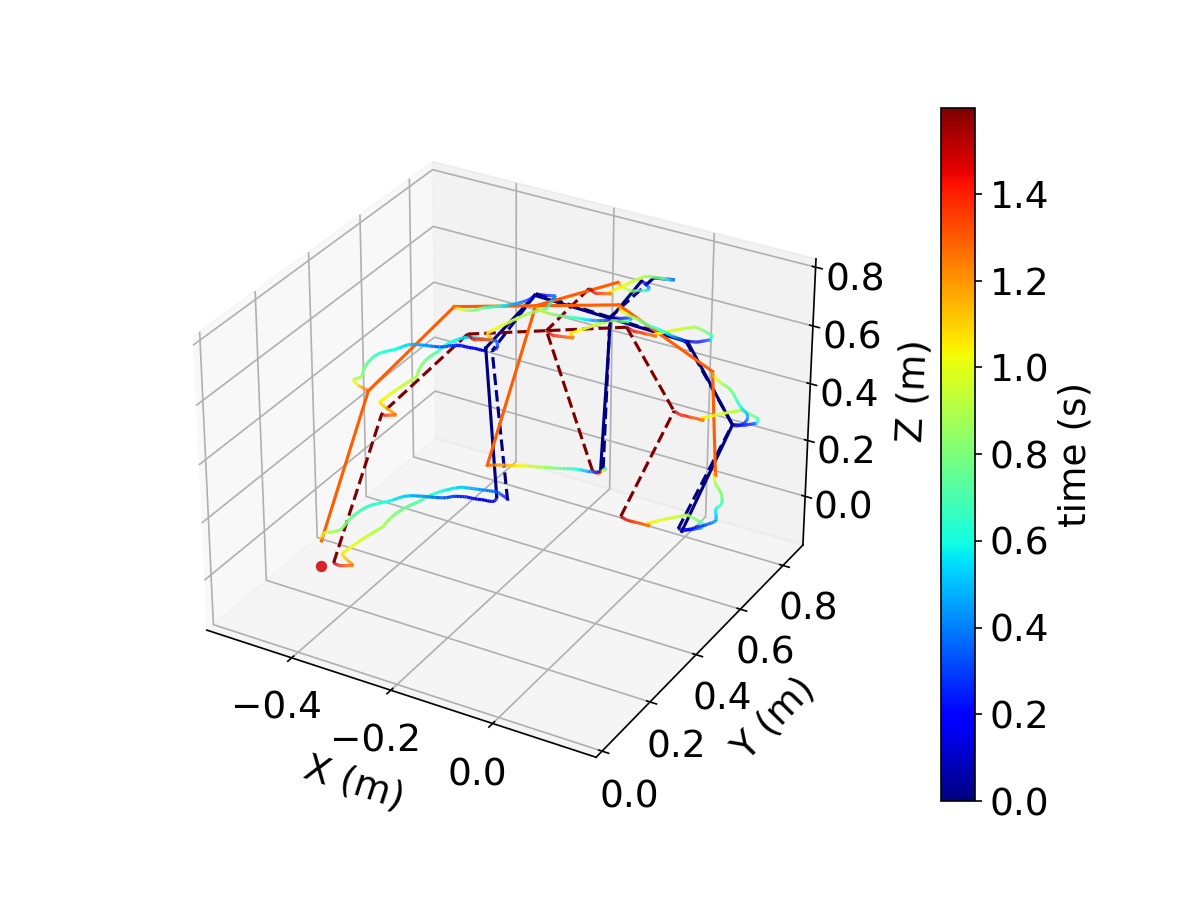

prediction


<IPython.core.display.Javascript object>


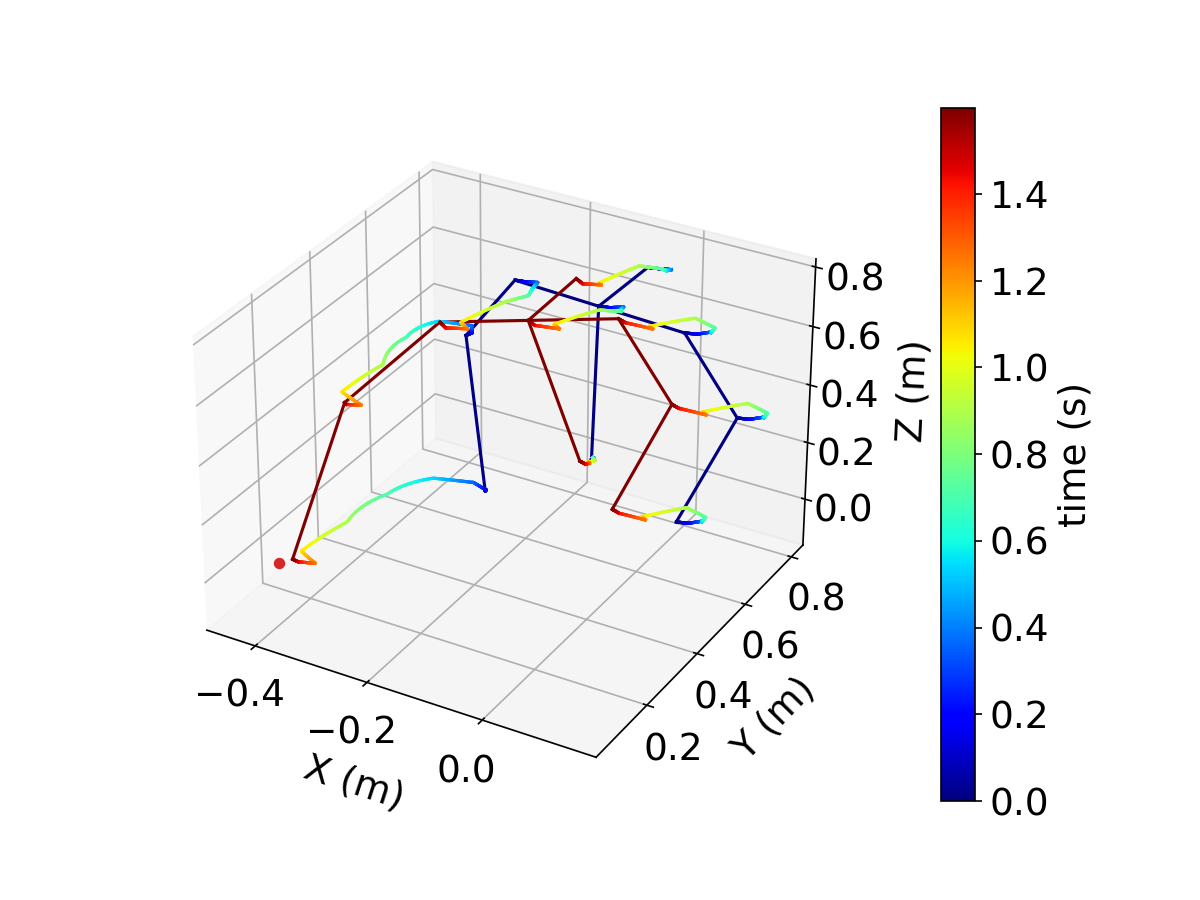

actual


<IPython.core.display.Javascript object>


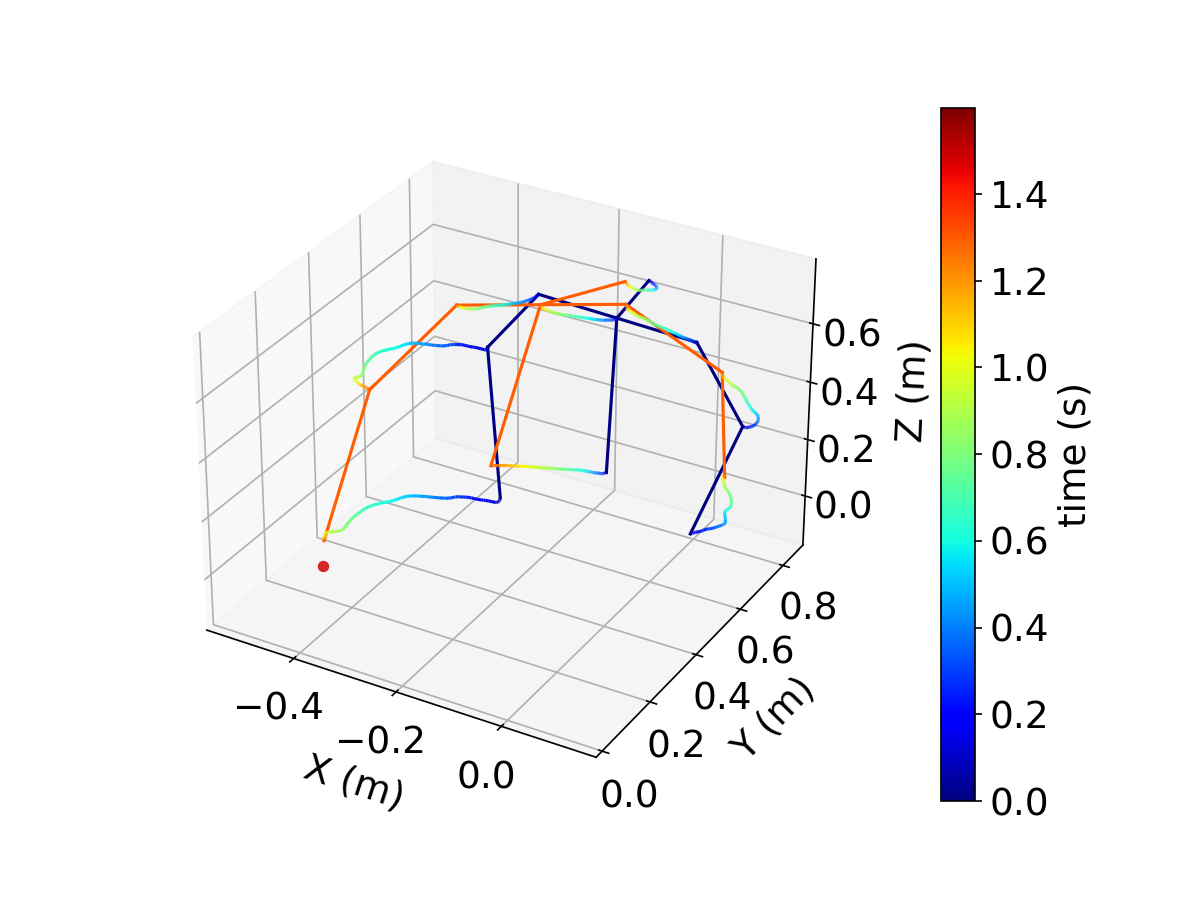

In [39]:
x = data[:,0]-data[0,0]
pred_x = prediction[:,0]+pred_start-data[0,0]
%matplotlib notebook
# fig = plt.figure(figsize=(8,8))
# ax = fig.add_subplot(projection='3d')
dt = 0.01
print('{},{}'.format(data.shape[0],prediction.shape[0]))
colors = pl.cm.jet(np.linspace(0,1,prediction.shape[0]))
colors2 = pl.cm.jet(np.linspace(0,1,math.ceil(max(x[-1]/dt+1,pred_x[-1]/dt+1))))
colors = colors2
reaching_tgt = data[0,1:4]
# ax.scatter(reaching_tgt[0],reaching_tgt[1],reaching_tgt[2],color='tab:red')
# for i in range(prediction.shape[0]):
#     c_ = colors[round(pred_x[i]/dt)]
#     ax.plot([prediction[i,32],prediction[i,35]],[prediction[i,33],prediction[i,36]],[prediction[i,34],prediction[i,37]],c=c_,linestyle='dashed')
#     ax.plot([prediction[i,38],prediction[i,35]],[prediction[i,39],prediction[i,36]],[prediction[i,40],prediction[i,37]],c=c_,linestyle='dashed')
#     ax.plot([prediction[i,41],prediction[i,35]],[prediction[i,42],prediction[i,36]],[prediction[i,43],prediction[i,37]],c=c_,linestyle='dashed')
#     ax.plot([prediction[i,41],prediction[i,44]],[prediction[i,42],prediction[i,45]],[prediction[i,43],prediction[i,46]],c=c_,linestyle='dashed')
#     ax.plot([prediction[i,47],prediction[i,44]],[prediction[i,48],prediction[i,45]],[prediction[i,49],prediction[i,46]],c=c_,linestyle='dashed')
#     ax.plot([prediction[i,50],prediction[i,35]],[prediction[i,51],prediction[i,36]],[prediction[i,52],prediction[i,37]],c=c_,linestyle='dashed')
#     ax.plot([prediction[i,50],prediction[i,53]],[prediction[i,51],prediction[i,54]],[prediction[i,52],prediction[i,55]],c=c_,linestyle='dashed')
#     ax.plot([prediction[i,56],prediction[i,53]],[prediction[i,57],prediction[i,54]],[prediction[i,58],prediction[i,55]],c=c_,linestyle='dashed')
# for i in range(data.shape[0]):
#     c_ = colors2[round(x[i]/dt)]
#     act_data = data
#     ax.plot([act_data[i,36],act_data[i,39]],[act_data[i,37],act_data[i,40]],[act_data[i,38],act_data[i,41]],c=c_)
#     ax.plot([act_data[i,42],act_data[i,39]],[act_data[i,43],act_data[i,40]],[act_data[i,44],act_data[i,41]],c=c_)
#     ax.plot([act_data[i,45],act_data[i,39]],[act_data[i,46],act_data[i,40]],[act_data[i,47],act_data[i,41]],c=c_)
#     ax.plot([act_data[i,45],act_data[i,48]],[act_data[i,46],act_data[i,49]],[act_data[i,47],act_data[i,50]],c=c_)
#     ax.plot([act_data[i,51],act_data[i,48]],[act_data[i,52],act_data[i,49]],[act_data[i,53],act_data[i,50]],c=c_)
#     ax.plot([act_data[i,54],act_data[i,39]],[act_data[i,55],act_data[i,40]],[act_data[i,56],act_data[i,41]],c=c_)
#     ax.plot([act_data[i,54],act_data[i,57]],[act_data[i,55],act_data[i,58]],[act_data[i,56],act_data[i,59]],c=c_)
#     ax.plot([act_data[i,60],act_data[i,57]],[act_data[i,61],act_data[i,58]],[act_data[i,62],act_data[i,59]],c=c_)

print('actual and prediction')
fig2 = plt.figure(figsize=(8,6))
ax2 = fig2.add_subplot(projection='3d')
reaching_tgt = data[0,1:4]
ax2.scatter(reaching_tgt[0],reaching_tgt[1],reaching_tgt[2],color='tab:red')
i=0
c_ = colors[i]
ax2.plot([prediction[i,32],prediction[i,35]],[prediction[i,33],prediction[i,36]],[prediction[i,34],prediction[i,37]],c=c_,linestyle='dashed', linewidth=1.5)
ax2.plot([prediction[i,38],prediction[i,35]],[prediction[i,39],prediction[i,36]],[prediction[i,40],prediction[i,37]],c=c_,linestyle='dashed', linewidth=1.5)
ax2.plot([prediction[i,41],prediction[i,35]],[prediction[i,42],prediction[i,36]],[prediction[i,43],prediction[i,37]],c=c_,linestyle='dashed', linewidth=1.5)
ax2.plot([prediction[i,41],prediction[i,44]],[prediction[i,42],prediction[i,45]],[prediction[i,43],prediction[i,46]],c=c_,linestyle='dashed', linewidth=1.5)
ax2.plot([prediction[i,47],prediction[i,44]],[prediction[i,48],prediction[i,45]],[prediction[i,49],prediction[i,46]],c=c_,linestyle='dashed', linewidth=1.5)
ax2.plot([prediction[i,50],prediction[i,35]],[prediction[i,51],prediction[i,36]],[prediction[i,52],prediction[i,37]],c=c_,linestyle='dashed', linewidth=1.5)
ax2.plot([prediction[i,50],prediction[i,53]],[prediction[i,51],prediction[i,54]],[prediction[i,52],prediction[i,55]],c=c_,linestyle='dashed', linewidth=1.5)
ax2.plot([prediction[i,56],prediction[i,53]],[prediction[i,57],prediction[i,54]],[prediction[i,58],prediction[i,55]],c=c_,linestyle='dashed', linewidth=1.5)
c_ = colors2[i]
ax2.plot([data[i,36],data[i,39]],[data[i,37],data[i,40]],[data[i,38],data[i,41]],c=c_, linewidth=1.5)
ax2.plot([data[i,42],data[i,39]],[data[i,43],data[i,40]],[data[i,44],data[i,41]],c=c_, linewidth=1.5)
ax2.plot([data[i,45],data[i,39]],[data[i,46],data[i,40]],[data[i,47],data[i,41]],c=c_, linewidth=1.5)
ax2.plot([data[i,45],data[i,48]],[data[i,46],data[i,49]],[data[i,47],data[i,50]],c=c_, linewidth=1.5)
ax2.plot([data[i,51],data[i,48]],[data[i,52],data[i,49]],[data[i,53],data[i,50]],c=c_, linewidth=1.5)
ax2.plot([data[i,54],data[i,39]],[data[i,55],data[i,40]],[data[i,56],data[i,41]],c=c_, linewidth=1.5)
ax2.plot([data[i,54],data[i,57]],[data[i,55],data[i,58]],[data[i,56],data[i,59]],c=c_, linewidth=1.5)
ax2.plot([data[i,60],data[i,57]],[data[i,61],data[i,58]],[data[i,62],data[i,59]],c=c_, linewidth=1.5)
i=-1
c_ = colors[round(pred_x[-1]/dt)]
ax2.plot([prediction[i,32],prediction[i,35]],[prediction[i,33],prediction[i,36]],[prediction[i,34],prediction[i,37]],c=c_,linestyle='dashed', linewidth=1.5)
ax2.plot([prediction[i,38],prediction[i,35]],[prediction[i,39],prediction[i,36]],[prediction[i,40],prediction[i,37]],c=c_,linestyle='dashed', linewidth=1.5)
ax2.plot([prediction[i,41],prediction[i,35]],[prediction[i,42],prediction[i,36]],[prediction[i,43],prediction[i,37]],c=c_,linestyle='dashed', linewidth=1.5)
ax2.plot([prediction[i,41],prediction[i,44]],[prediction[i,42],prediction[i,45]],[prediction[i,43],prediction[i,46]],c=c_,linestyle='dashed', linewidth=1.5)
ax2.plot([prediction[i,47],prediction[i,44]],[prediction[i,48],prediction[i,45]],[prediction[i,49],prediction[i,46]],c=c_,linestyle='dashed', linewidth=1.5)
ax2.plot([prediction[i,50],prediction[i,35]],[prediction[i,51],prediction[i,36]],[prediction[i,52],prediction[i,37]],c=c_,linestyle='dashed', linewidth=1.5)
ax2.plot([prediction[i,50],prediction[i,53]],[prediction[i,51],prediction[i,54]],[prediction[i,52],prediction[i,55]],c=c_,linestyle='dashed', linewidth=1.5)
ax2.plot([prediction[i,56],prediction[i,53]],[prediction[i,57],prediction[i,54]],[prediction[i,58],prediction[i,55]],c=c_,linestyle='dashed', linewidth=1.5)
c_ = colors2[round(x[-1]/dt)]
ax2.plot([data[i,36],data[i,39]],[data[i,37],data[i,40]],[data[i,38],data[i,41]],c=c_, linewidth=1.5)
ax2.plot([data[i,42],data[i,39]],[data[i,43],data[i,40]],[data[i,44],data[i,41]],c=c_, linewidth=1.5)
ax2.plot([data[i,45],data[i,39]],[data[i,46],data[i,40]],[data[i,47],data[i,41]],c=c_, linewidth=1.5)
ax2.plot([data[i,45],data[i,48]],[data[i,46],data[i,49]],[data[i,47],data[i,50]],c=c_, linewidth=1.5)
ax2.plot([data[i,51],data[i,48]],[data[i,52],data[i,49]],[data[i,53],data[i,50]],c=c_, linewidth=1.5)
ax2.plot([data[i,54],data[i,39]],[data[i,55],data[i,40]],[data[i,56],data[i,41]],c=c_, linewidth=1.5)
ax2.plot([data[i,54],data[i,57]],[data[i,55],data[i,58]],[data[i,56],data[i,59]],c=c_, linewidth=1.5)
ax2.plot([data[i,60],data[i,57]],[data[i,61],data[i,58]],[data[i,62],data[i,59]],c=c_, linewidth=1.5)
for i in range(prediction.shape[0]-1):
    c_ = colors[round(pred_x[i]/dt)]
    for j in range(9):
        ax2.plot([prediction[i,j*3+32],prediction[i+1,j*3+32]],[prediction[i,j*3+33],prediction[i+1,j*3+33]],[prediction[i,j*3+34],prediction[i+1,j*3+34]],c=c_,ls=(0, (1, 10)))

for i in range(data.shape[0]-1):
    c_ = colors2[round(x[i]/dt)]
    for j in range(9):
        ax2.plot([data[i,j*3+36],data[i+1,j*3+36]],[data[i,j*3+37],data[i+1,j*3+37]],[data[i,j*3+38],data[i+1,j*3+38]],c=c_,ls=(0, (5, 10)))
cb = cm.ScalarMappable(norm=None, cmap=pl.cm.jet)
cb.set_array(x)
cbar = fig2.colorbar(cb, ax=ax2, pad=0.1)
cbar.ax.tick_params(labelsize=f_size)
cbar.set_label(label='time (s)',fontsize=f_size)
ax2.set_xlabel('X (m)',fontsize=f_size, labelpad=10)
ax2.set_ylabel('Y (m)',fontsize=f_size, labelpad=10)
ax2.set_zlabel('Z (m)',fontsize=f_size, labelpad=10)
ax2.tick_params(labelsize=f_size)

print('prediction')
fig3 = plt.figure(figsize=(8,6))
ax3 = fig3.add_subplot(projection='3d')
reaching_tgt = data[0,1:4]
ax3.scatter(reaching_tgt[0],reaching_tgt[1],reaching_tgt[2],color='tab:red')
i=0
c_ = colors[i]
ls = 'solid'
ax3.plot([prediction[i,32],prediction[i,35]],[prediction[i,33],prediction[i,36]],[prediction[i,34],prediction[i,37]],c=c_,linestyle=ls, linewidth=1.5)
ax3.plot([prediction[i,38],prediction[i,35]],[prediction[i,39],prediction[i,36]],[prediction[i,40],prediction[i,37]],c=c_,linestyle=ls, linewidth=1.5)
ax3.plot([prediction[i,41],prediction[i,35]],[prediction[i,42],prediction[i,36]],[prediction[i,43],prediction[i,37]],c=c_,linestyle=ls, linewidth=1.5)
ax3.plot([prediction[i,41],prediction[i,44]],[prediction[i,42],prediction[i,45]],[prediction[i,43],prediction[i,46]],c=c_,linestyle=ls, linewidth=1.5)
ax3.plot([prediction[i,47],prediction[i,44]],[prediction[i,48],prediction[i,45]],[prediction[i,49],prediction[i,46]],c=c_,linestyle=ls, linewidth=1.5)
ax3.plot([prediction[i,50],prediction[i,35]],[prediction[i,51],prediction[i,36]],[prediction[i,52],prediction[i,37]],c=c_,linestyle=ls, linewidth=1.5)
ax3.plot([prediction[i,50],prediction[i,53]],[prediction[i,51],prediction[i,54]],[prediction[i,52],prediction[i,55]],c=c_,linestyle=ls, linewidth=1.5)
ax3.plot([prediction[i,56],prediction[i,53]],[prediction[i,57],prediction[i,54]],[prediction[i,58],prediction[i,55]],c=c_,linestyle=ls, linewidth=1.5)

i=-1
c_ = colors[round(pred_x[-1]/dt)]
ax3.plot([prediction[i,32],prediction[i,35]],[prediction[i,33],prediction[i,36]],[prediction[i,34],prediction[i,37]],c=c_,linestyle=ls, linewidth=1.5)
ax3.plot([prediction[i,38],prediction[i,35]],[prediction[i,39],prediction[i,36]],[prediction[i,40],prediction[i,37]],c=c_,linestyle=ls, linewidth=1.5)
ax3.plot([prediction[i,41],prediction[i,35]],[prediction[i,42],prediction[i,36]],[prediction[i,43],prediction[i,37]],c=c_,linestyle=ls, linewidth=1.5)
ax3.plot([prediction[i,41],prediction[i,44]],[prediction[i,42],prediction[i,45]],[prediction[i,43],prediction[i,46]],c=c_,linestyle=ls, linewidth=1.5)
ax3.plot([prediction[i,47],prediction[i,44]],[prediction[i,48],prediction[i,45]],[prediction[i,49],prediction[i,46]],c=c_,linestyle=ls, linewidth=1.5)
ax3.plot([prediction[i,50],prediction[i,35]],[prediction[i,51],prediction[i,36]],[prediction[i,52],prediction[i,37]],c=c_,linestyle=ls, linewidth=1.5)
ax3.plot([prediction[i,50],prediction[i,53]],[prediction[i,51],prediction[i,54]],[prediction[i,52],prediction[i,55]],c=c_,linestyle=ls, linewidth=1.5)
ax3.plot([prediction[i,56],prediction[i,53]],[prediction[i,57],prediction[i,54]],[prediction[i,58],prediction[i,55]],c=c_,linestyle=ls, linewidth=1.5)
for i in range(prediction.shape[0]-1):
    c_ = colors[round(pred_x[i]/dt)]
    for j in range(9):
        ax3.plot([prediction[i,j*3+32],prediction[i+1,j*3+32]],[prediction[i,j*3+33],prediction[i+1,j*3+33]],[prediction[i,j*3+34],prediction[i+1,j*3+34]],c=c_,ls='solid')#(0, (1, 10)))
ax3.set_xlabel('X (m)',fontsize=f_size, labelpad=10)
ax3.set_ylabel('Y (m)',fontsize=f_size, labelpad=10)
ax3.set_zlabel('Z (m)',fontsize=f_size, labelpad=10)
ax3.tick_params(labelsize=f_size)
cb = cm.ScalarMappable(norm=None, cmap=pl.cm.jet)
cb.set_array(x)
cbar = fig3.colorbar(cb, ax=ax3, pad=0.1)
cbar.ax.tick_params(labelsize=f_size)
cbar.set_label(label='time (s)',fontsize=f_size)

print('actual')
fig4 = plt.figure(figsize=(8,6))
ax4 = fig4.add_subplot(projection='3d')
reaching_tgt = data[0,1:4]
ax4.scatter(reaching_tgt[0],reaching_tgt[1],reaching_tgt[2],color='tab:red')
i=0
c_ = colors2[i]
ax4.plot([data[i,36],data[i,39]],[data[i,37],data[i,40]],[data[i,38],data[i,41]],c=c_, linewidth=1.5)
ax4.plot([data[i,42],data[i,39]],[data[i,43],data[i,40]],[data[i,44],data[i,41]],c=c_, linewidth=1.5)
ax4.plot([data[i,45],data[i,39]],[data[i,46],data[i,40]],[data[i,47],data[i,41]],c=c_, linewidth=1.5)
ax4.plot([data[i,45],data[i,48]],[data[i,46],data[i,49]],[data[i,47],data[i,50]],c=c_, linewidth=1.5)
ax4.plot([data[i,51],data[i,48]],[data[i,52],data[i,49]],[data[i,53],data[i,50]],c=c_, linewidth=1.5)
ax4.plot([data[i,54],data[i,39]],[data[i,55],data[i,40]],[data[i,56],data[i,41]],c=c_, linewidth=1.5)
ax4.plot([data[i,54],data[i,57]],[data[i,55],data[i,58]],[data[i,56],data[i,59]],c=c_, linewidth=1.5)
ax4.plot([data[i,60],data[i,57]],[data[i,61],data[i,58]],[data[i,62],data[i,59]],c=c_, linewidth=1.5)
i=-1
c_ = colors2[round(x[-1]/dt)]
ax4.plot([data[i,36],data[i,39]],[data[i,37],data[i,40]],[data[i,38],data[i,41]],c=c_, linewidth=1.5)
ax4.plot([data[i,42],data[i,39]],[data[i,43],data[i,40]],[data[i,44],data[i,41]],c=c_, linewidth=1.5)
ax4.plot([data[i,45],data[i,39]],[data[i,46],data[i,40]],[data[i,47],data[i,41]],c=c_, linewidth=1.5)
ax4.plot([data[i,45],data[i,48]],[data[i,46],data[i,49]],[data[i,47],data[i,50]],c=c_, linewidth=1.5)
ax4.plot([data[i,51],data[i,48]],[data[i,52],data[i,49]],[data[i,53],data[i,50]],c=c_, linewidth=1.5)
ax4.plot([data[i,54],data[i,39]],[data[i,55],data[i,40]],[data[i,56],data[i,41]],c=c_, linewidth=1.5)
ax4.plot([data[i,54],data[i,57]],[data[i,55],data[i,58]],[data[i,56],data[i,59]],c=c_, linewidth=1.5)
ax4.plot([data[i,60],data[i,57]],[data[i,61],data[i,58]],[data[i,62],data[i,59]],c=c_, linewidth=1.5)

for i in range(data.shape[0]-1):
    c_ = colors2[round(x[i]/dt)]
    for j in range(9):
        ax4.plot([data[i,j*3+36],data[i+1,j*3+36]],[data[i,j*3+37],data[i+1,j*3+37]],[data[i,j*3+38],data[i+1,j*3+38]],c=c_,ls=(0, (5, 10)))
ax4.set_xlabel('X (m)',fontsize=f_size, labelpad=10)
ax4.set_ylabel('Y (m)',fontsize=f_size, labelpad=10)
ax4.set_zlabel('Z (m)',fontsize=f_size, labelpad=10)
ax4.tick_params(labelsize=f_size)
cb = cm.ScalarMappable(norm=None, cmap=pl.cm.jet)
cb.set_array(x)
cbar = fig4.colorbar(cb, ax=ax4, pad=0.1)
cbar.set_label(label='time (s)',fontsize=f_size)
cbar.ax.tick_params(labelsize=f_size)
plt.show()

In [40]:
def data_for_cylinder_along_z(center_x,center_y,radius,height_z,n_theta = 30,n_z=10):
    z = np.linspace(0, height_z, n_z)
    theta = np.linspace(0, 2*np.pi, n_theta)
    theta_grid, z_grid=np.meshgrid(theta, z)
    x_grid = radius*np.cos(theta_grid) + center_x
    y_grid = radius*np.sin(theta_grid) + center_y
    print(x_grid.shape)
    n_pts = x_grid.shape[0]*x_grid.shape[1]
#     points = np.concatenate((np.expand_dims(x_grid, axis=0),np.expand_dims(y_grid, axis=0),np.expand_dims(z_grid, axis=0)),axis=0)
    points = np.concatenate((np.expand_dims(x_grid.flatten(), axis=1),np.expand_dims(y_grid.flatten(), axis=1),np.expand_dims(z_grid.flatten(), axis=1)),axis=1)
    return points


In [41]:
dimensions = [0.569,0.25,0.328,0.285,0.4,0.285,0.4]
radii = [0.12,0.05,.1,.04,.03,.04,.03]
def generate_human_cylinders(n_theta=30,n_z=10):
    link_meshes = {}
    link_meshes['torso'] = data_for_cylinder_along_z(0,0,radii[0],dimensions[0],n_theta,n_z)
    link_meshes['neck'] = data_for_cylinder_along_z(0,0,radii[1],dimensions[1],n_theta,n_z)
    link_meshes['r_upperarm'] = data_for_cylinder_along_z(0,0,radii[3],dimensions[3],n_theta,n_z)
    link_meshes['l_upperarm'] = data_for_cylinder_along_z(0,0,radii[5],dimensions[5],n_theta,n_z)
    link_meshes['r_forearm'] = data_for_cylinder_along_z(0,0,radii[4],dimensions[4],n_theta,n_z)
    link_meshes['l_forearm'] = data_for_cylinder_along_z(0,0,radii[6],dimensions[6],n_theta,n_z)
    return link_meshes

In [42]:
n_z = 3
n_theta = 30
links = generate_human_cylinders(n_theta,n_z)
print(links['r_upperarm'].shape)

(3, 30)
(3, 30)
(3, 30)
(3, 30)
(3, 30)
(3, 30)
(90, 3)


In [43]:
def set_axes_equal(ax):
    '''Make axes of 3D plot have equal scale so that spheres appear as spheres,
    cubes as cubes, etc..  This is one possible solution to Matplotlib's
    ax.set_aspect('equal') and ax.axis('equal') not working for 3D.

    Input
      ax: a matplotlib axis, e.g., as output from plt.gca().
    '''

    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    x_middle = np.mean(x_limits)
    y_range = abs(y_limits[1] - y_limits[0])
    y_middle = np.mean(y_limits)
    z_range = abs(z_limits[1] - z_limits[0])
    z_middle = np.mean(z_limits)

    # The plot bounding box is a sphere in the sense of the infinity
    # norm, hence I call half the max range the plot radius.
    plot_radius = 0.5*max([x_range, y_range, z_range])

    ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius])
    ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
    ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])

In [44]:
class data_step:
    def __init__(self,t):
        self.t = t
        self.meshes = []

<IPython.core.display.Javascript object>


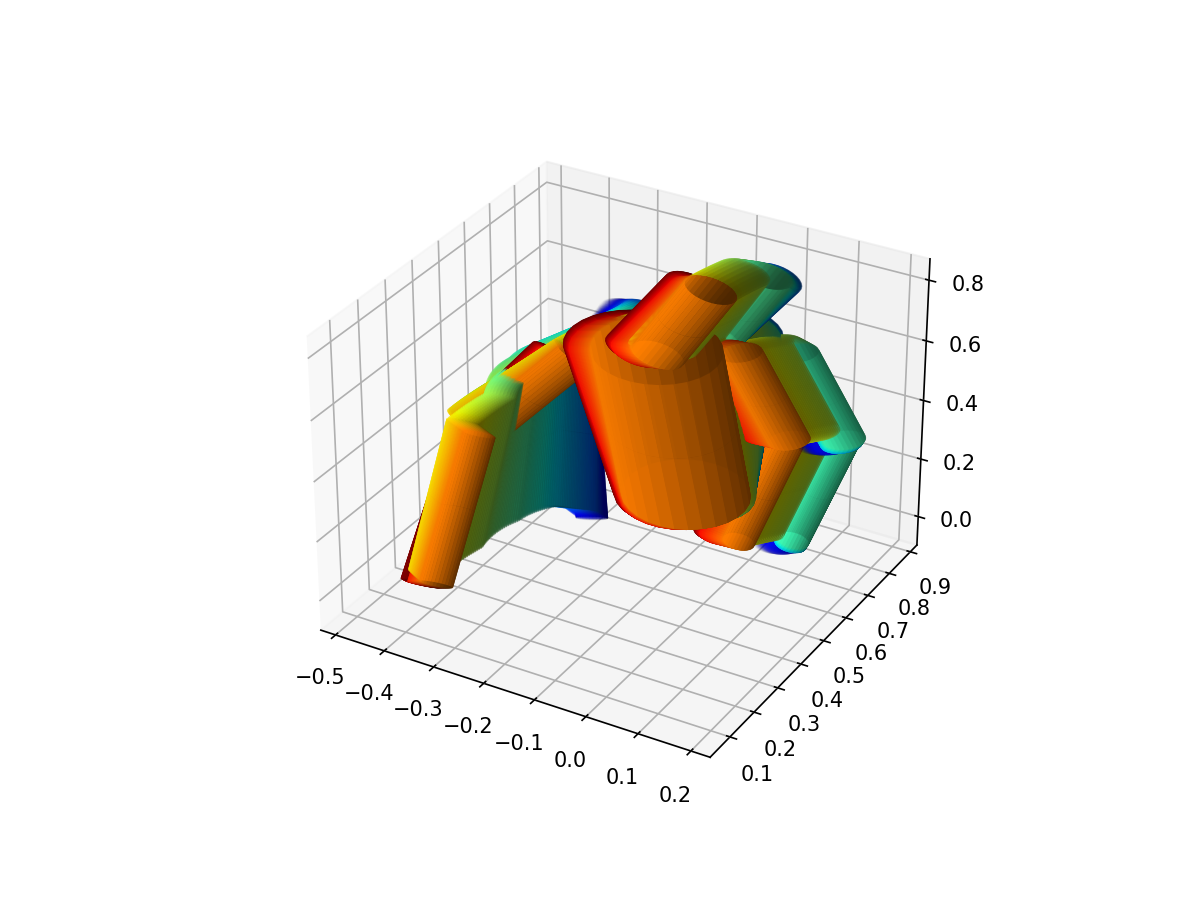

[0 1 3 4 5 6]
[ 0.09090702 -0.04481909 -0.00394677  0.99484249]
[-0.07554001  0.20823982 -0.01275071  0.97507297]
[ 0.78295331 -0.52413452 -0.00423999  0.33503604]
[ 0.88498307  0.18784057 -0.00730909  0.42598998]
[-0.32961491  0.93080904  0.          0.15795106]
[ 0.07784241 -0.99024604  0.          0.11555664]
198


In [45]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(projection='3d')
colors2 = pl.cm.jet(np.linspace(0,1,math.ceil(max(x[-1]/dt+1,pred_x[-1]/dt+1))))
j_idx = np.array([32,35,41,44,50,53])
q_idx = np.array([0,1,3,4,5,6])
xyzw = np.array([1,2,3,0])
link_names = ['torso','neck','r_upperarm','r_forearm','l_upperarm','l_forearm']
prediction_steps = []
rotations = []
print(q_idx)
for i in range(6):
    print(prediction[-1,q_idx[i]*4+4+xyzw])
    rotations.append(R.from_quat(prediction[:,q_idx[i]*4+4+xyzw]).as_matrix())
    rotations[-1] = np.append(rotations[-1],np.expand_dims(prediction[:,j_idx[i]:j_idx[i]+3],2),axis=2)
    rotations[-1] = np.append(rotations[-1],np.expand_dims(np.tile(np.array([0,0,0,1]),(prediction.shape[0],1)),1),axis=1)
# fig = go.Figure()
for j in range(prediction.shape[0]):
    prediction_steps.append(copy.deepcopy(data_step(prediction[j,0])))
    for i in range(6):
        m = links[link_names[i]]
        m = (rotations[i][j]@np.concatenate((m,np.ones((m.shape[0],1))),axis=1).T).T#(np.concatenate((m,np.ones((m.shape[0],1))),axis=1)@r[j])
        prediction_steps[j].meshes.append(copy.deepcopy(m))
        c_ = colors[round(pred_x[j]/dt)]
#         fig.add_trace(go.Surface(x=m[:,0].reshape((n_z,n_theta)), y=m[:,1].reshape((n_z,n_theta)), z=m[:,2].reshape((n_z,n_theta)), surfacecolor = c_, opacity=0.2))
        ax.plot_surface(m[:,0].reshape((n_z,n_theta)),m[:,1].reshape((n_z,n_theta)), m[:,2].reshape((n_z,n_theta)), alpha=0.01+0.99*(j/prediction.shape[0]), linewidth=0.0,color=c_, edgecolors=c_)
    
#     print(prediction_steps[-1].meshes[1][0])
# set_axes_equal(ax)
print(len(prediction_steps))
# py.iplot(fig)
# fig.show()
plt.show()

In [46]:
actual_steps = []
rotations = []
print(q_idx)
for i in range(6):
    rotations.append(R.from_quat(data[:,q_idx[i]*4+8+xyzw]).as_matrix())
    rotations[-1] = np.append(rotations[-1],np.expand_dims(data[:,j_idx[i]+4:j_idx[i]+4+3],2),axis=2)
    rotations[-1] = np.append(rotations[-1],np.expand_dims(np.tile(np.array([0,0,0,1]),(data.shape[0],1)),1),axis=1)
# fig = go.Figure()
for j in range(data.shape[0]):
    actual_steps.append(copy.deepcopy(data_step(data[j,0]-data[0,0])))
    for i in range(6):
        m = links[link_names[i]]
        m = (rotations[i][j]@np.concatenate((m,np.ones((m.shape[0],1))),axis=1).T).T#(np.concatenate((m,np.ones((m.shape[0],1))),axis=1)@r[j])
        actual_steps[j].meshes.append(copy.deepcopy(m))

[0 1 3 4 5 6]


In [47]:
def draw_box(x,y,z):
    triangles = []
    xyz = np.array([[x[0],y[0],z[0]], #0
                    [x[0],y[1],z[0]], #1
                    [x[0],y[0],z[1]], #2
                    [x[0],y[1],z[1]], #3
                    [x[1],y[0],z[0]], #4
                    [x[1],y[1],z[0]], #5
                    [x[1],y[0],z[1]], #6
                    [x[1],y[1],z[1]]])#7
    print(xyz)
    pt_list = np.array([[0,1,2], #left
                        [1,2,3], #left
                        [0,2,4], #close
                        [2,4,6], #close 
                        [1,3,5], #far
                        [5,7,3], #far
                        [4,5,6], #right
                        [5,6,7], #right
                        [2,3,6], #top
                        [3,6,7], #top
                        [0,1,4], #bottom
                        [1,4,5]])#bottom
    for j in range(pt_list.shape[0]):
        triangle = []
        for i in range(3):
            triangle.append(xyz[pt_list[j,i]])
        triangles.append(triangle)
    print(triangles)
    return triangles

def draw_box_lines(x,y,z,ax):
    xyz = np.array([[x[0],y[0],z[0]], #0
                    [x[0],y[1],z[0]], #1
                    [x[0],y[0],z[1]], #2
                    [x[0],y[1],z[1]], #3
                    [x[1],y[0],z[0]], #4
                    [x[1],y[1],z[0]], #5
                    [x[1],y[0],z[1]], #6
                    [x[1],y[1],z[1]]])#7
    print(xyz)
    pt_list = np.array([[0,1], #left
                        [0,2], #left
                        [4,5], #close
                        [4,6], #close 
                        [0,4], #far
                        [1,5], #far
                        [2,6], #right
                        [3,7], #right
                        [2,3], #top
                        [6,7], #top
                        [1,3], #bottom
                        [5,7]])#bottom
    for j in range(pt_list.shape[0]):
        ax.plot(xyz[pt_list[j],0],xyz[pt_list[j],1],xyz[pt_list[j],2],color='black',linewidth=2,zorder=10)

<IPython.core.display.Javascript object>


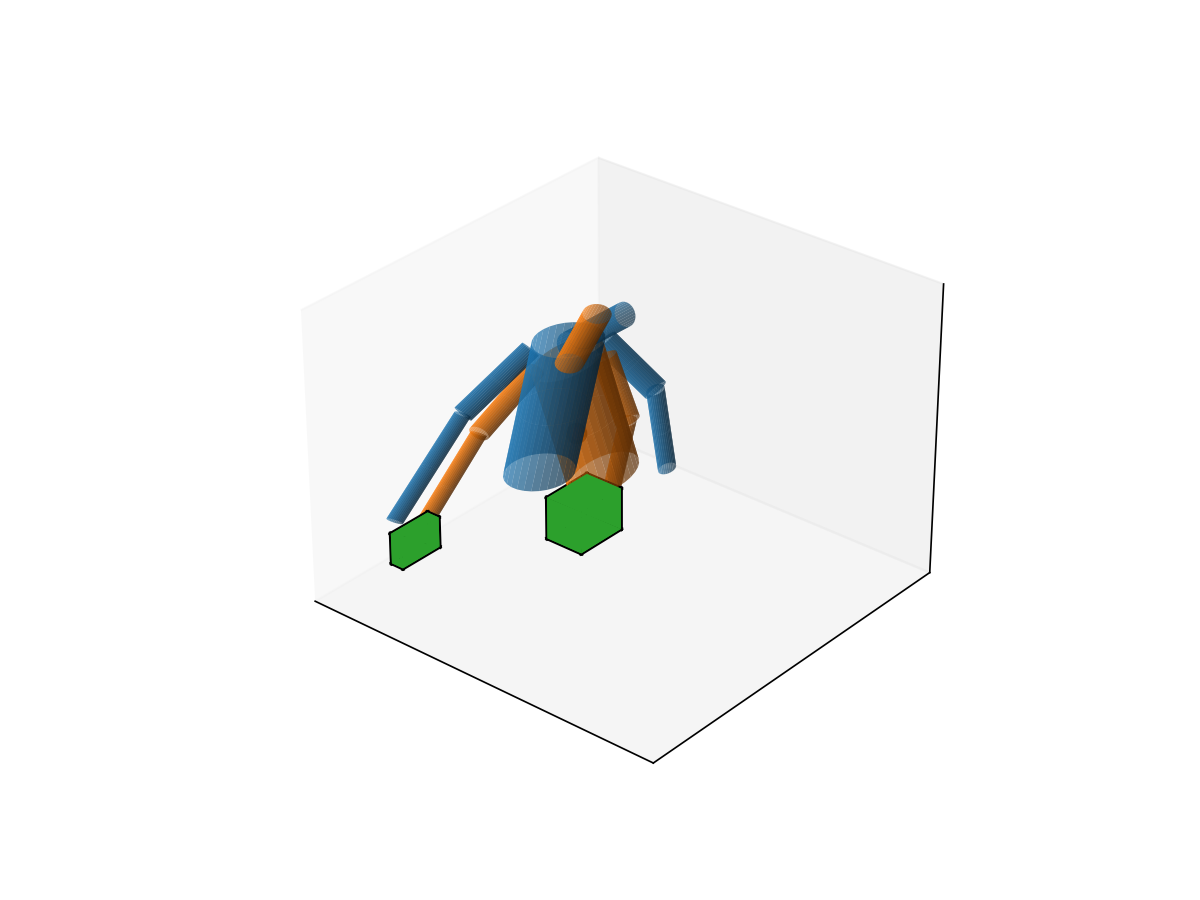

[[-0.06  0.41  0.  ]
 [-0.06  0.57  0.  ]
 [-0.06  0.41  0.18]
 [-0.06  0.57  0.18]
 [ 0.12  0.41  0.  ]
 [ 0.12  0.57  0.  ]
 [ 0.12  0.41  0.18]
 [ 0.12  0.57  0.18]]
[[array([-0.06,  0.41,  0.  ]), array([-0.06,  0.57,  0.  ]), array([-0.06,  0.41,  0.18])], [array([-0.06,  0.57,  0.  ]), array([-0.06,  0.41,  0.18]), array([-0.06,  0.57,  0.18])], [array([-0.06,  0.41,  0.  ]), array([-0.06,  0.41,  0.18]), array([0.12, 0.41, 0.  ])], [array([-0.06,  0.41,  0.18]), array([0.12, 0.41, 0.  ]), array([0.12, 0.41, 0.18])], [array([-0.06,  0.57,  0.  ]), array([-0.06,  0.57,  0.18]), array([0.12, 0.57, 0.  ])], [array([0.12, 0.57, 0.  ]), array([0.12, 0.57, 0.18]), array([-0.06,  0.57,  0.18])], [array([0.12, 0.41, 0.  ]), array([0.12, 0.57, 0.  ]), array([0.12, 0.41, 0.18])], [array([0.12, 0.57, 0.  ]), array([0.12, 0.41, 0.18]), array([0.12, 0.57, 0.18])], [array([-0.06,  0.41,  0.18]), array([-0.06,  0.57,  0.18]), array([0.12, 0.41, 0.18])], [array([-0.06,  0.57,  0.18]), array([0.1

In [48]:
%matplotlib notebook
plt.ion()
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(projection='3d')
x1 = np.array([-0.06,0.12])
y1 = np.array([0.41,0.57])
z1 = np.array([0,0.18])

# np.array(([[,0],[,0],[,0.18],[]]))
ax.add_collection3d(Poly3DCollection(draw_box(x1,y1,z1),facecolor='tab:green',zorder=0))
draw_box_lines(x1,y1,z1,ax)
x = np.array([-0.381-0.03,-0.381+0.03])
y = np.array([0.127-0.07,0.127+0.07])
z = np.array([0,0.13])

# np.array(([[,0],[,0],[,0.18],[]]))
ax.add_collection3d(Poly3DCollection(draw_box(x,y,z),facecolor='tab:green',zorder=0))
draw_box_lines(x,y,z,ax)
tgt = [-0.01,0.49,0.43]
ax.scatter(tgt[0],tgt[1],tgt[2],s=70,c='r',edgecolors='black',zorder=11,linewidths=2.0)
ax.view_init(elev=30., azim=-50)
ax.set_xticks([]) 
ax.set_yticks([]) 
ax.set_zticks([]) 
fig.show()
fig.canvas.draw()
j = 0
k = 0
s = [None for i in range(12)]
prediction_done = False
act_done = False
max_t = max(data[-1,0]-data[0,0],pred_x[-1])
t_steps = np.arange(0,max_t,0.01)
t_saves = t_steps[np.round(np.linspace(1,t_steps.shape[0]-1,4)).astype(int)]
t_saves[2]-=0.3
for t in t_saves:#np.arange(0,max_t,0.01):
    update_draw = False
    draw = False
    while (prediction_steps[j].t<t) and (not prediction_done):
        draw = True
        j+=1
        if j==len(prediction_steps):
            prediction_done = True
        j = min(len(prediction_steps)-1,j)
    if draw:
        for i in range(6):
            m = prediction_steps[j].meshes[i]
            if s[i] is not None:
                s[i].remove()
            s[i] = ax.plot_surface(m[:,0].reshape((n_z,n_theta)),m[:,1].reshape((n_z,n_theta)), m[:,2].reshape((n_z,n_theta)), alpha=0.7, linewidth=0.0,color='tab:orange', edgecolors='tab:orange')     
        update_draw = True
    draw = False
    while (actual_steps[k].t<t) and (not act_done):
        draw = True
        k+=1
        if k==len(actual_steps):
            act_done = True
        k = min(len(actual_steps)-1,k)
    if draw:
        for i in range(6):
            m = actual_steps[k].meshes[i]
            if s[i+6] is not None:
                s[i+6].remove()
            s[i+6] = ax.plot_surface(m[:,0].reshape((n_z,n_theta)),m[:,1].reshape((n_z,n_theta)), m[:,2].reshape((n_z,n_theta)), alpha=0.7, linewidth=0.0,color='tab:blue', edgecolors='tab:blue')
        update_draw = True
#     plt.draw()
    if update_draw:
        fig.canvas.draw()
    if np.isin(t_saves,t).any():
        print('save')
        print(os.path.join(this_pack,'vid_imgs','img_{}_{}.png'.format(file_num,time.time())))
        plt.savefig(os.path.join(this_pack,'vid_imgs','img_{}_{}.png'.format(file_num,time.time())))
#     time.sleep(0.001)
    plt.pause(0.001)
#     plt.show(block=False)
print('done')
plt.ioff()
plt.show()

[[-0.06  0.41  0.  ]
 [-0.06  0.57  0.  ]
 [-0.06  0.41  0.18]
 [-0.06  0.57  0.18]
 [ 0.12  0.41  0.  ]
 [ 0.12  0.57  0.  ]
 [ 0.12  0.41  0.18]
 [ 0.12  0.57  0.18]]
[[array([-0.06,  0.41,  0.  ]), array([-0.06,  0.57,  0.  ]), array([-0.06,  0.41,  0.18])], [array([-0.06,  0.57,  0.  ]), array([-0.06,  0.41,  0.18]), array([-0.06,  0.57,  0.18])], [array([-0.06,  0.41,  0.  ]), array([-0.06,  0.41,  0.18]), array([0.12, 0.41, 0.  ])], [array([-0.06,  0.41,  0.18]), array([0.12, 0.41, 0.  ]), array([0.12, 0.41, 0.18])], [array([-0.06,  0.57,  0.  ]), array([-0.06,  0.57,  0.18]), array([0.12, 0.57, 0.  ])], [array([0.12, 0.57, 0.  ]), array([0.12, 0.57, 0.18]), array([-0.06,  0.57,  0.18])], [array([0.12, 0.41, 0.  ]), array([0.12, 0.57, 0.  ]), array([0.12, 0.41, 0.18])], [array([0.12, 0.57, 0.  ]), array([0.12, 0.41, 0.18]), array([0.12, 0.57, 0.18])], [array([-0.06,  0.41,  0.18]), array([-0.06,  0.57,  0.18]), array([0.12, 0.41, 0.18])], [array([-0.06,  0.57,  0.18]), array([0.1

<IPython.core.display.Javascript object>


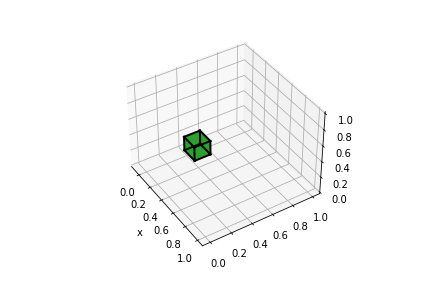

In [60]:
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.pyplot as plt


import numpy as np

# phi = np.linspace(0,2*np.pi, 7)
# x = np.cos(phi) + np.sin(phi)
# y = -np.sin(phi) + np.cos(phi)
# z = np.cos(phi)*0.12+0.7

# a = np.zeros((len(phi)-1, 9))
# a[:,0] = x[:-1]
# a[:,1] = y[:-1]
# a[:,2] = z[:-1]
# a[:,3:6] = np.roll( a[:,0:3], -1, axis=0)
# a[:,8] = np.ones_like(phi[:-1])
# a = np.around(a, 2)

x = np.array([-0.06,0.12])
y = np.array([0.41,0.57])
z = np.array([0,0.18])

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# fc = ["crimson" if i%2 else "gold" for i in range(a.shape[0])]

# poly3d = [[ a[i, j*3:j*3+3] for j in range(3)  ] for i in range(1)]

# print(poly3d)

# ax.add_collection3d(Poly3DCollection(poly3d, facecolors=fc, linewidths=1))
ax.add_collection3d(Poly3DCollection(draw_box(x,y,z),facecolor='tab:green'))
draw_box_lines(x,y,z,ax)
ax.set_xlabel('x')
plt.show()